In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '20'

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import layers
from keras.layers import Dense, GlobalAveragePooling1D, Embedding, Dropout
from keras.models import Sequential
from keras.losses import CategoricalCrossentropy, CategoricalFocalCrossentropy
from keras.metrics import Precision, Recall, CategoricalAccuracy, F1Score, TruePositives, TrueNegatives, FalseNegatives, FalsePositives
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences

In [3]:
url = "https://github.com/Alireza-Akhavan/text-classification/raw/main/6-persian-topics.zip"
dataset = tf.keras.utils.get_file("6-persian-topics.zip", url,
                                    extract=True, cache_dir='.',
                                    cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), '6-persian-topics')


In [4]:
ry = []
ryazi = os.path.join(dataset_dir, 'ریاضیات/')
for r in os.listdir(ryazi):
    ry.append(os.path.join(dataset_dir, 'ریاضیات/', r))
beh = []
behdasht = os.path.join(dataset_dir, 'بهداشت و سلامت/')
for r in os.listdir(behdasht):
    beh.append(os.path.join(dataset_dir, 'بهداشت و سلامت/', r))
jog = []
joghrafia = os.path.join(dataset_dir, 'جغرافیا و مکانها/')
for r in os.listdir(joghrafia):
    jog.append(os.path.join(dataset_dir, 'جغرافیا و مکانها/', r))
fan = []
fanavari = os.path.join(dataset_dir, 'فناوری و علوم کاربردی و تکنولوژی/')
for r in os.listdir(fanavari):
    fan.append(os.path.join(dataset_dir, 'فناوری و علوم کاربردی و تکنولوژی/', r))
var = []
varzesh = os.path.join(dataset_dir, 'ورزش/')
for r in os.listdir(varzesh):
    var.append(os.path.join(dataset_dir, 'ورزش/', r))
di = []
din = os.path.join(dataset_dir, 'دین و اعتقاد/')
for r in os.listdir(din):
    di.append(os.path.join(dataset_dir, 'دین و اعتقاد/', r))
ry.extend(beh)
ry.extend(jog)
ry.extend(fan)
ry.extend(var)
ry.extend(di)

for i in ry:
    file = open(i, 'r')
    content = file.read()
    if len(content.split(' ')) <= 5:
        os.remove(i)
    file.close()

In [5]:
classes = os.listdir(dataset_dir)
dataset = []
labels = []
for c in classes:
    files = os.listdir(os.path.join(dataset_dir, c))
    for f in files:
        file_path = os.path.join(os.path.join(dataset_dir, c), f)
        dataset.append(file_path)
        labels.append(classes.index(c))


train_data, valid_data, train_target, valid_target = train_test_split(dataset, labels, test_size=0.2)



In [6]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    stripped_ye = tf.strings.regex_replace(stripped_html, 'ي', 'ی')
    stripped_camma = tf.strings.regex_replace(stripped_ye, '،', ' ')
    stripped_colon = tf.strings.regex_replace(stripped_camma, ':', ' ')
    stripped_he = tf.strings.regex_replace(stripped_colon, 'هٔ', 'ه')
    stripped_ke = tf.strings.regex_replace(stripped_he, 'ك', 'ک')
    stripped_alef = tf.strings.regex_replace(stripped_ke, 'آ', 'ا')
    stripped_english = tf.strings.regex_replace(stripped_alef, '[a-zA-Z]', ' ')
    return tf.strings.regex_replace(stripped_english, '[%s]' % re.escape(string.punctuation), '')


In [7]:
max_feature = 20000
vectorize_layer = layers.TextVectorization(
    max_tokens=max_feature,
    standardize=custom_standardization,
    output_sequence_length=250)

In [8]:
import re
import string

AUTOTUNE = tf.data.experimental.AUTOTUNE
BUFFER_SIZE = 10000
BATCH_SIZE = 64

def get_text_with_target(path, target):
    target = tf.one_hot(target, depth=6, dtype='float32')
    content = tf.io.read_file(path)
    return content, target

def vectorize_text(text, target):
    text = vectorize_layer(text)
    return text, target

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_target))
validation_dataset = tf.data.Dataset.from_tensor_slices((valid_data, valid_target))

train_dataset = train_dataset.map(get_text_with_target, num_parallel_calls=AUTOTUNE)
vectorize_layer.adapt(train_dataset.map(lambda t, l: t, num_parallel_calls=AUTOTUNE))
train_dataset = train_dataset.map(vectorize_text, num_parallel_calls=AUTOTUNE)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE, drop_remainder=True).prefetch(AUTOTUNE)
validation_dataset = validation_dataset.map(get_text_with_target, num_parallel_calls=AUTOTUNE).map(vectorize_text, num_parallel_calls=AUTOTUNE).cache().batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

In [9]:
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_feature, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(100),
  layers.Dropout(0.5),
  layers.Dense(6, activation='softmax')])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          320000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 100)               1700      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 606       
                                                                 
Total params: 322306 (1.23 MB)
Trainable params: 322306 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [11]:
model.compile(loss=CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=[
                  tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.F1Score(name='f1-score')
              ])

In [12]:
train_iterator = train_dataset.as_numpy_iterator()

class_counts = {}
class_indices = {}

class_index = 0
for data, labels in train_iterator:
    for label in labels:
        label_tuple = tuple(label)
        if label_tuple not in class_counts:
            class_counts[label_tuple] = 1
            class_indices[label_tuple] = class_index
            class_index += 1
        else:
            class_counts[label_tuple] += 1

total_samples = sum(class_counts.values())

class_weights = {
    class_indices[label]: total_samples / count
    for label, count in class_counts.items()
}

for label, count in class_counts.items():
    print(f"Class {label}: {count} samples")

for class_index, weight in class_weights.items():
    print(f"Class {class_index} weight: {weight}")

Class (0.0, 0.0, 0.0, 1.0, 0.0, 0.0): 4980 samples
Class (0.0, 1.0, 0.0, 0.0, 0.0, 0.0): 17432 samples
Class (0.0, 0.0, 1.0, 0.0, 0.0, 0.0): 5136 samples
Class (0.0, 0.0, 0.0, 0.0, 0.0, 1.0): 410 samples
Class (0.0, 0.0, 0.0, 0.0, 1.0, 0.0): 1505 samples
Class (1.0, 0.0, 0.0, 0.0, 0.0, 0.0): 297 samples
Class 0 weight: 5.975903614457831
Class 1 weight: 1.7072051399724644
Class 2 weight: 5.794392523364486
Class 3 weight: 72.58536585365853
Class 4 weight: 19.774086378737543
Class 5 weight: 100.20202020202021


In [13]:
history = model.fit(train_dataset, epochs=20, validation_data=validation_dataset, class_weight=class_weights)

Epoch 1/20


I0000 00:00:1715080761.716012   72209 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


465/465 [==============================] - 37s 72ms/step - loss: 6.0719 - accuracy: 0.5966 - precision: 0.7818 - recall: 0.4750 - f1-score: 0.4185 - val_loss: 0.3146 - val_accuracy: 0.9018 - val_precision: 0.9415 - val_recall: 0.8764 - val_f1-score: 0.6456
Epoch 2/20
465/465 [==============================] - 11s 22ms/step - loss: 0.9722 - accuracy: 0.9559 - precision: 0.9672 - recall: 0.9466 - f1-score: 0.8039 - val_loss: 0.1510 - val_accuracy: 0.9569 - val_precision: 0.9652 - val_recall: 0.9508 - val_f1-score: 0.8321
Epoch 3/20
465/465 [==============================] - 7s 13ms/step - loss: 0.4180 - accuracy: 0.9805 - precision: 0.9840 - recall: 0.9779 - f1-score: 0.9216 - val_loss: 0.1968 - val_accuracy: 0.9487 - val_precision: 0.9552 - val_recall: 0.9437 - val_f1-score: 0.8342
Epoch 4/20
465/465 [==============================] - 5s 10ms/step - loss: 0.5546 - accuracy: 0.9767 - precision: 0.9797 - recall: 0.9746 - f1-score: 0.9242 - val_loss: 0.1269 - val_accuracy: 0.9724 - val_pre

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1-score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1-score'])

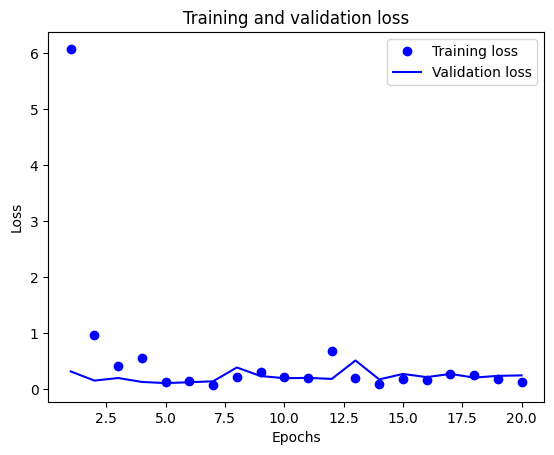

In [15]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

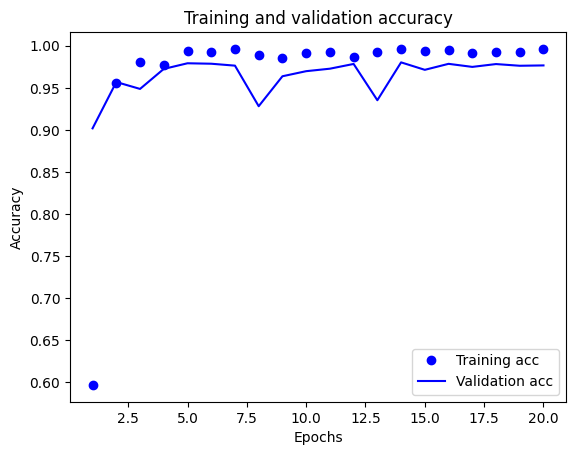

In [16]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [32]:
predictions = model.predict(validation_dataset) 
predicted_classes = tf.math.argmax(predictions, axis=-1)
from sklearn.metrics import classification_report 
report = classification_report(valid_target, predicted_classes) 

print(report)

117/117 [==============================] - 0s 727us/step
              precision    recall  f1-score   support

           0       0.85      0.72      0.78        79
           1       0.99      0.99      0.99      4289
           2       0.96      0.96      0.96      1296
           3       0.97      1.00      0.98      1282
           4       0.96      0.94      0.95       387
           5       0.75      0.89      0.81       108

    accuracy                           0.98      7441
   macro avg       0.91      0.92      0.91      7441
weighted avg       0.98      0.98      0.98      7441

